# Weak imposition of Dirichlet conditions for the Poisson problem
Author: Jørgen S. Dokken

In this section, we will go through how to solve the Poisson problem from the [Fundamentals](fundamentals.ipynb) tutorial using Nitsche's method {cite}`Nitsche1971`.
The idea of weak imposition is that we add additional terms to the variational formulation to impose the boundary condition, instead of modifying the matrix system using strong imposition (lifting).

We start by importing the required modules and creating the mesh and function space for our solution

In [3]:
import dolfinx
import numpy
from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 div, dx, ds, grad, inner, grad)

N = 8
mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, N, N)
V = dolfinx.FunctionSpace(mesh, ("CG", 1))

Next, we create a function containing the exact solution (which will also be used in the Dirichlet boundary condition) and the corresponding source function for the right hand side.

In [4]:
uD = dolfinx.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)
dolfinx.cpp.la.scatter_forward(uD.x)
x = SpatialCoordinate(mesh)
f = -div(grad(1 + x[0]**2 + 2 * x[1]**2))

As opposed to the first tutorial, we now have to have another look at the variational form.
We start by integrating the problem by parts, to obtain
\begin{align}
    \int_{\Omega} \nabla u \cdot \nabla v~\mathrm{d}x - \int_{\partial\Omega}\nabla u \cdot n v~\mathrm{d}s = \int_{\Omega} f v~\mathrm{d}x.
\end{align}
As we are not using strong enforcement, we do not set the trace of the test function to $0$ on the outer boundary.
Instead, we add the following two terms to the variational formulation
\begin{align}
    -\int_{\partial\Omega} \nabla  v \cdot n (u-u_D)~\mathrm{d}s + \frac{\alpha}{h} \int_{\partial\Omega} (u-u_D)v~\mathrm{d}s.
\end{align}
where the first term enforces symmetry to the bilinear form, while the latter term enforces coercivity.
$u_D$ is the known Dirichlet condition, and $h$ is the circumradius of the mesh element.
We create bilinear and linear form, $a$ and $L$
\begin{align}
    a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v~\mathrm{d}x + \int_{\partial\Omega}-(n \cdot\nabla u) v - (n \cdot \nabla v) u - \frac{\alpha}{h} uv~\mathrm{d}s,\\
    L(v) &= \int_{\Omega} fv~\mathrm{d}x + \int_{\partial\Omega}  -(\nabla u_D \cdot n) v  -(\nabla v \cdot n) u_D + \frac{\alpha}{h} u_Dv~\mathrm{d}s
\end{align}

In [5]:
u = TrialFunction(V)
v = TestFunction(V)
n = FacetNormal(mesh)
h = 2 * Circumradius(mesh)
alpha = 10
a = inner(grad(u), grad(v)) * dx - inner(n, grad(u)) * v * ds
a += - inner(n, grad(v)) * u * ds + alpha / h * inner(u, v) * ds
L = inner(f, v) * dx 
L += - inner(n, grad(v)) * uD * ds + alpha / h * inner(uD, v) * ds

As we now have the variational form, we can solve the linear problem

In [6]:
problem = dolfinx.fem.LinearProblem(a, L)
uh = problem.solve()

We compute the error of the computation by comparing it to the analytical solution

In [7]:
error_form = inner(uh-uD, uh-uD) * dx
errorL2 = numpy.sqrt(dolfinx.fem.assemble_scalar(error_form))
print(fr"$L^2$-error: {errorL2:.2e}")

$L^2$-error: 1.59e-03


We observe that the $L^2$-error is of the same magnitude as in the first tutorial.
As in the previous tutorial, we also compute the error at the mesh vertices

In [8]:
u_vertex_values = uh.compute_point_values()
u_ex_vertex_values = uD.compute_point_values()
error_max = numpy.max(numpy.abs(u_vertex_values - u_ex_vertex_values))
print(f"Error_max : {error_max:.2e}")

Error_max : 5.31e-03


We observe that as we weakly impose the boundary condition, we no longer fullfill the equation to machine precision at the mesh vertices. We also plot the solution using `pyvista`

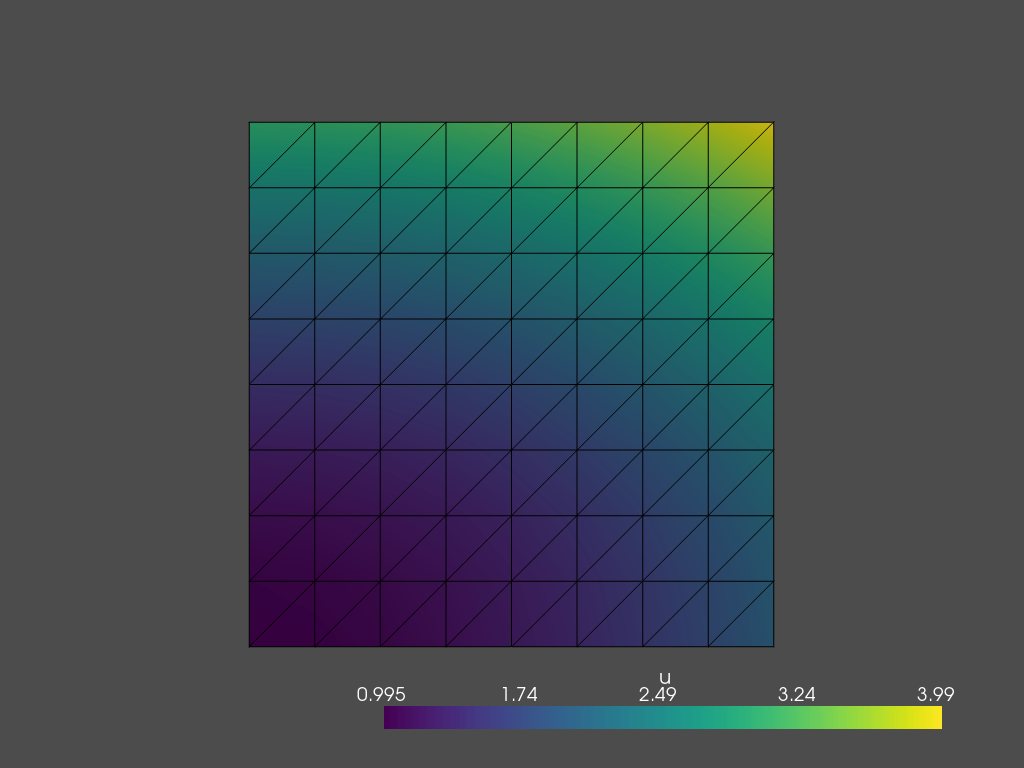

In [9]:
import dolfinx.plot
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
import pyvista
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
grid.point_arrays["u"] = u_vertex_values.real
grid.set_active_scalars("u")
pyvista.start_xvfb(wait=0.05)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
figure = plotter.screenshot("nitsche.png")

```{bibliography}
   :filter: cited and ({"chapter1/nitsche"} >= docnames)
```